# EX12 다음에 볼 영화 예측하기
***************
> **평가항목**
> - 1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.
> - 2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.
> - 3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.

## 1. 데이터 전처리

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- UserId와 Time을 이용하여 하나의 세션으로 정의

In [3]:
data['UserId'].nunique(), data['ItemId'].nunique(), data['Time'].nunique()

(6040, 3706, 458455)

In [4]:
df = data.groupby(['UserId', 'Time'])['ItemId'].count().reset_index()
df.reset_index(inplace=True)
df

,index,UserId,Time,ItemId
0,0,1,978300019,1
1,1,1,978300055,3
2,2,1,978300103,1
3,3,1,978300172,1
4,4,1,978300275,1
...,...,...,...,...
471158,471158,6040,997454398,1
471159,471159,6040,997454429,1
471160,471160,6040,997454464,2
471161,471161,6040,997454486,1


In [5]:
data = pd.merge(data, df, on=['UserId', 'Time'])
data.drop(columns='ItemId_y', inplace=True)
data.columns = ['UserId', 'ItemId', 'Rating', 'Time', 'SessionId']
data

,UserId,ItemId,Rating,Time,SessionId
0,1,3186,4,978300019,0
1,1,1270,5,978300055,1
2,1,1721,4,978300055,1
3,1,1022,5,978300055,1
4,1,2340,3,978300103,2
...,...,...,...,...,...
1000204,6040,2917,4,997454429,471159
1000205,6040,1921,4,997454464,471160
1000206,6040,1784,3,997454464,471160
1000207,6040,161,3,997454486,471161


In [6]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
0         1
1         3
2         1
3         1
4         1
         ..
471158    1
471159    1
471160    2
471161    1
471162    1
Length: 471163, dtype: int64

- 각 세션에 대해 길이를 출력하고, 길이는 하나의 세션이 몇 개의 영화를 평가했는지에 대한 정보를 담고 있다.

In [7]:
session_length.median(), session_length.mean()

(2.0, 2.1228513274599234)

- 한 세션당 평가한 영화의 중앙값은 2, 평균은 약 2.12

In [8]:
session_length.min(), session_length.max()

(1, 30)

- 한 세션당 평가한 영화의 최솟값은 1, 최댓값은 30

In [9]:
session_length.quantile(0.999)

10.0

- 10개보다 많은 영화에 대해 평가한 데이터들은 이상치로 설정

In [10]:
long_session = session_length[session_length==30].index[0]
data[data['SessionId']==long_session]

,UserId,ItemId,Rating,Time,SessionId
112347,731,3044,4,975528402,55117
112348,731,1455,3,975528402,55117
112349,731,1639,5,975528402,55117
112350,731,3244,4,975528402,55117
112351,731,1656,2,975528402,55117
112352,731,3426,4,975528402,55117
112353,731,1829,2,975528402,55117
112354,731,2675,4,975528402,55117
112355,731,802,3,975528402,55117
112356,731,803,5,975528402,55117


In [11]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1    0.480048
2    0.713936
3    0.847350
4    0.919684
5    0.958639
6    0.979132
7    0.989772
8    0.994989
9    0.997604
dtype: float64

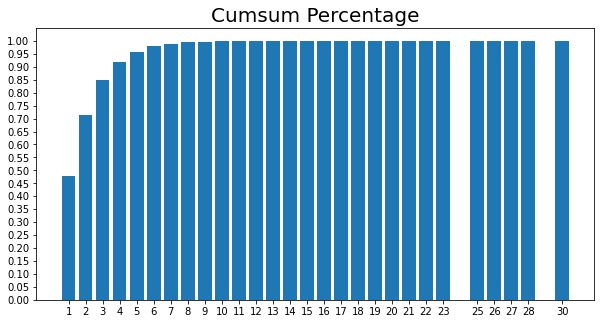

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(x=length_percent_cumsum.index,
        height=length_percent_cumsum)
plt.xticks(length_percent_cumsum.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage', size=20)
plt.show()

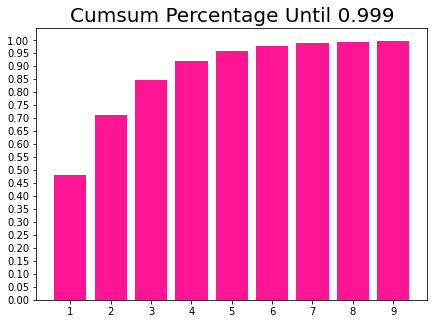

In [13]:
plt.figure(figsize=(7, 5))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='deeppink')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

- 세션의 길이가 9이하인 데이터만 그래프로 출력

### 시간분석

In [14]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


In [15]:
print(dt.datetime.utcfromtimestamp(oldest).strftime('%Y-%m-%d %H:%M:%S'))
print(dt.datetime.utcfromtimestamp(latest).strftime('%Y-%m-%d %H:%M:%S'))

2000-04-25 23:05:32
2003-02-28 17:49:50


In [16]:
print(len(data[data['Time'] > latest - (86400*365*3)]))  # 최근 3년 데이터 수
print(len(data[data['Time'] > latest - (86400*365*2)]))  # 최근 2년 데이터 수
print(len(data[data['Time'] > latest - (86400*365*1)]))  # 최근 1년 데이터 수

1000209
69349
21704


- 1일을 [초(second)] 단위로 환산 86400

In [17]:
data = data[['SessionId', 'UserId', 'Time', 'ItemId', 'Rating']]
data

,SessionId,UserId,Time,ItemId,Rating
0,0,1,978300019,3186,4
1,1,1,978300055,1270,5
2,1,1,978300055,1721,4
3,1,1,978300055,1022,5
4,2,1,978300103,2340,3
...,...,...,...,...,...
1000204,471159,6040,997454429,2917,4
1000205,471160,6040,997454464,1921,4
1000206,471160,6040,997454464,1784,3
1000207,471161,6040,997454486,161,3


In [18]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - (86400*n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - (86400*n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [19]:
tr, test = split_by_date(data, n_days=100)
tr, val = split_by_date(tr, n_days=100)

In [20]:
def stats_info(data: pd.DataFrame, status: str):
    first_time = dt.datetime.utcfromtimestamp(data["Time"].min()).strftime('%Y-%m-%d %H:%M:%S')
    last_time = dt.datetime.utcfromtimestamp(data["Time"].max()).strftime('%Y-%m-%d %H:%M:%S')
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {first_time}\n'
          f'\t Last Time : {last_time}\n')

In [21]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 989923
	 Sessions: 6039
	 Items: 3702
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-08-12 13:53:29

* valid Set Stats Info
	 Events: 5209
	 Sessions: 245
	 Items: 1949
	 First Time : 2002-08-13 00:40:06
	 Last Time : 2002-11-20 16:38:40

* test Set Stats Info
	 Events: 5073
	 Sessions: 254
	 Items: 1893
	 First Time : 2002-11-20 20:30:02
	 Last Time : 2003-02-28 17:49:50



In [22]:
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

- train data를 기준으로 인덱싱
- id2idx에 없는 아이템은 모르는 값(-1)으로 처리

In [23]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## 2. 미니 배치 구성

In [24]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [25]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,SessionId,UserId,Time,ItemId,Rating,item_idx
0,0,1,978300019,3186,4,0
1,1,1,978300055,1270,5,1
2,1,1,978300055,1721,4,2
3,1,1,978300055,1022,5,3
4,2,1,978300103,2340,3,4
5,3,1,978300172,1836,5,5
6,4,1,978300275,3408,4,6
7,5,1,978300719,2804,5,7
8,5,1,978300719,1207,4,8
9,6,1,978300760,1193,5,9


In [26]:
tr_dataset.click_offsets

array([     0,      1,      4, ..., 989921, 989922, 989923], dtype=int32)

In [27]:
tr_dataset.session_idx

array([     0,      1,      2, ..., 463928, 463929, 463930])

In [28]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.
        
        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [29]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,SessionId,UserId,Time,ItemId,Rating,item_idx
0,0,1,978300019,3186,4,0
1,1,1,978300055,1270,5,1
2,1,1,978300055,1721,4,2
3,1,1,978300055,1022,5,3
4,2,1,978300103,2340,3,4
5,3,1,978300172,1836,5,5
6,4,1,978300275,3408,4,6
7,5,1,978300719,2804,5,7
8,5,1,978300719,1207,4,8
9,6,1,978300760,1193,5,9


In [30]:
iter_ex = iter(tr_data_loader)

In [31]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [19  1  7  9]
Label Item Idx are :       [20  2  8 10]
Previous Masked Input Idx are [0]


## 3. 모델 구성

In [32]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0

def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU, LSTM
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [34]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [60]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.5, lr=0.001, epochs=30, k=20)

In [61]:
model = create_model(args)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(64, 1, 3702)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      563100    
_________________________________________________________________
dropout_5 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_5 (Dense)              (64, 3702)                188802    
Total params: 751,902
Trainable params: 751,902
Non-trainable params: 0
_________________________________________________________________


## 4. 모델 학습

In [62]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

- epochs = 5

In [49]:
train_model(model, args)

Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.65] 

	 - Recall@20 epoch 1: 0.130682
	 - MRR@20    epoch 1: 0.041932



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.16] 

	 - Recall@20 epoch 2: 0.171165
	 - MRR@20    epoch 2: 0.059430



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0391, train_loss=6.03] 

	 - Recall@20 epoch 3: 0.187500
	 - MRR@20    epoch 3: 0.064550



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.97] 

	 - Recall@20 epoch 4: 0.191761
	 - MRR@20    epoch 4: 0.067068



Evaluation:  92%|█████████▏| 11/12 [00:08<00:00,  1.32it/s]

	 - Recall@20 epoch 5: 0.190341
	 - MRR@20    epoch 5: 0.069656



- epochs = 20

In [43]:
train_model(model, args)

Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0234, train_loss=6.66] 

	 - Recall@20 epoch 1: 0.129972
	 - MRR@20    epoch 1: 0.039691



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0781, train_loss=6.32]

	 - Recall@20 epoch 2: 0.172585
	 - MRR@20    epoch 2: 0.061197



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0391, train_loss=6.02] 

	 - Recall@20 epoch 3: 0.191051
	 - MRR@20    epoch 3: 0.065909



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.94]

	 - Recall@20 epoch 4: 0.191051
	 - MRR@20    epoch 4: 0.070926



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.84]

	 - Recall@20 epoch 5: 0.189631
	 - MRR@20    epoch 5: 0.071368



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.97] 

	 - Recall@20 epoch 6: 0.188210
	 - MRR@20    epoch 6: 0.073264



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.88]

	 - Recall@20 epoch 7: 0.190341
	 - MRR@20    epoch 7: 0.073289



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.89]

	 - Recall@20 epoch 8: 0.191051
	 - MRR@20    epoch 8: 0.072527



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.98] 

	 - Recall@20 epoch 9: 0.190341
	 - MRR@20    epoch 9: 0.074414



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.79] 

	 - Recall@20 epoch 10: 0.196023
	 - MRR@20    epoch 10: 0.073977



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.83] 

	 - Recall@20 epoch 11: 0.196733
	 - MRR@20    epoch 11: 0.071943



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.84]

	 - Recall@20 epoch 12: 0.196023
	 - MRR@20    epoch 12: 0.072517



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.87] 

	 - Recall@20 epoch 13: 0.200994
	 - MRR@20    epoch 13: 0.073984



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.85]

	 - Recall@20 epoch 14: 0.200994
	 - MRR@20    epoch 14: 0.073358



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.84] 

	 - Recall@20 epoch 15: 0.202415
	 - MRR@20    epoch 15: 0.072831



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.8] 

	 - Recall@20 epoch 16: 0.203835
	 - MRR@20    epoch 16: 0.072821



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.97] 

	 - Recall@20 epoch 17: 0.200994
	 - MRR@20    epoch 17: 0.073214



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.86]

	 - Recall@20 epoch 18: 0.203125
	 - MRR@20    epoch 18: 0.071191



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.83]

	 - Recall@20 epoch 19: 0.205256
	 - MRR@20    epoch 19: 0.072288



Evaluation:  92%|█████████▏| 11/12 [00:08<00:00,  1.31it/s]

	 - Recall@20 epoch 20: 0.203125
	 - MRR@20    epoch 20: 0.071087



- epochs = 30

In [38]:
train_model(model, args)

Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.77] 

	 - Recall@20 epoch 1: 0.130682
	 - MRR@20    epoch 1: 0.040295



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.21] 

	 - Recall@20 epoch 2: 0.171165
	 - MRR@20    epoch 2: 0.062270



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.07]

	 - Recall@20 epoch 3: 0.188920
	 - MRR@20    epoch 3: 0.069721



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0703, train_loss=6.22] 

	 - Recall@20 epoch 4: 0.195312
	 - MRR@20    epoch 4: 0.072024



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0938, train_loss=6.18]

	 - Recall@20 epoch 5: 0.195312
	 - MRR@20    epoch 5: 0.071236



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.94]

	 - Recall@20 epoch 6: 0.193892
	 - MRR@20    epoch 6: 0.071803



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0859, train_loss=6.1] 

	 - Recall@20 epoch 7: 0.195312
	 - MRR@20    epoch 7: 0.071567



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.02]

	 - Recall@20 epoch 8: 0.201705
	 - MRR@20    epoch 8: 0.071386



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0938, train_loss=6.06]

	 - Recall@20 epoch 9: 0.203835
	 - MRR@20    epoch 9: 0.071112



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.9] 

	 - Recall@20 epoch 10: 0.203125
	 - MRR@20    epoch 10: 0.073181



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.9]  

	 - Recall@20 epoch 11: 0.205256
	 - MRR@20    epoch 11: 0.072158



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.87]

	 - Recall@20 epoch 12: 0.206676
	 - MRR@20    epoch 12: 0.073091



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.92] 

	 - Recall@20 epoch 13: 0.208807
	 - MRR@20    epoch 13: 0.071525



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.81]

	 - Recall@20 epoch 14: 0.204545
	 - MRR@20    epoch 14: 0.072471



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.82] 

	 - Recall@20 epoch 15: 0.205966
	 - MRR@20    epoch 15: 0.072588



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.84] 

	 - Recall@20 epoch 16: 0.204545
	 - MRR@20    epoch 16: 0.071681



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.77] 

	 - Recall@20 epoch 17: 0.202415
	 - MRR@20    epoch 17: 0.074480



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.91]

	 - Recall@20 epoch 18: 0.199574
	 - MRR@20    epoch 18: 0.072064



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.83]

	 - Recall@20 epoch 19: 0.200284
	 - MRR@20    epoch 19: 0.073606



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.78]

	 - Recall@20 epoch 20: 0.200994
	 - MRR@20    epoch 20: 0.073296



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.71]

	 - Recall@20 epoch 21: 0.202415
	 - MRR@20    epoch 21: 0.071014



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.77] 

	 - Recall@20 epoch 22: 0.203125
	 - MRR@20    epoch 22: 0.071384



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.77]

	 - Recall@20 epoch 23: 0.203835
	 - MRR@20    epoch 23: 0.072374



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.85]

	 - Recall@20 epoch 24: 0.203835
	 - MRR@20    epoch 24: 0.073052



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.8] 

	 - Recall@20 epoch 25: 0.205256
	 - MRR@20    epoch 25: 0.072225



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0859, train_loss=5.75]

	 - Recall@20 epoch 26: 0.203125
	 - MRR@20    epoch 26: 0.073543



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.7] 

	 - Recall@20 epoch 27: 0.200284
	 - MRR@20    epoch 27: 0.073268



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.63]

	 - Recall@20 epoch 28: 0.198153
	 - MRR@20    epoch 28: 0.073422



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0703, train_loss=5.73]

	 - Recall@20 epoch 29: 0.193892
	 - MRR@20    epoch 29: 0.070778



Evaluation:  92%|█████████▏| 11/12 [00:08<00:00,  1.32it/s]

	 - Recall@20 epoch 30: 0.191761
	 - MRR@20    epoch 30: 0.069587



In [54]:
# dropout 변경
train_model(model, args)

Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.83] 

	 - Recall@20 epoch 1: 0.119318
	 - MRR@20    epoch 1: 0.035718



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.22]

	 - Recall@20 epoch 2: 0.171165
	 - MRR@20    epoch 2: 0.056256



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0781, train_loss=6.32]

	 - Recall@20 epoch 3: 0.188920
	 - MRR@20    epoch 3: 0.064804



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0859, train_loss=6.26] 

	 - Recall@20 epoch 4: 0.193182
	 - MRR@20    epoch 4: 0.065732



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0547, train_loss=5.99] 

	 - Recall@20 epoch 5: 0.193182
	 - MRR@20    epoch 5: 0.067084



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0391, train_loss=6.03]

	 - Recall@20 epoch 6: 0.190341
	 - MRR@20    epoch 6: 0.067510



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0391, train_loss=5.96]

	 - Recall@20 epoch 7: 0.192472
	 - MRR@20    epoch 7: 0.069409



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.91]

	 - Recall@20 epoch 8: 0.193892
	 - MRR@20    epoch 8: 0.068528



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0859, train_loss=6.17] 

	 - Recall@20 epoch 9: 0.196733
	 - MRR@20    epoch 9: 0.067407



Evaluation:  92%|█████████▏| 11/12 [00:08<00:00,  1.32it/s]

	 - Recall@20 epoch 10: 0.196023
	 - MRR@20    epoch 10: 0.068701



- drop_rate=0.5

In [59]:
train_model(model, args)

def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.00781, train_loss=7.12]

	 - Recall@20 epoch 1: 0.087358
	 - MRR@20    epoch 1: 0.025311



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.43] 

	 - Recall@20 epoch 2: 0.159091
	 - MRR@20    epoch 2: 0.052798



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.35]

	 - Recall@20 epoch 3: 0.177557
	 - MRR@20    epoch 3: 0.059056



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.28] 

	 - Recall@20 epoch 4: 0.188920
	 - MRR@20    epoch 4: 0.064938



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0547, train_loss=6.14]

	 - Recall@20 epoch 5: 0.196023
	 - MRR@20    epoch 5: 0.068248



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0391, train_loss=6.47]

	 - Recall@20 epoch 6: 0.193892
	 - MRR@20    epoch 6: 0.067993



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0703, train_loss=6.11]

	 - Recall@20 epoch 7: 0.194602
	 - MRR@20    epoch 7: 0.068919



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.24] 

	 - Recall@20 epoch 8: 0.195312
	 - MRR@20    epoch 8: 0.068529



Train:   0%|          | 0/4109 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.1] 

	 - Recall@20 epoch 9: 0.192472
	 - MRR@20    epoch 9: 0.067051



Evaluation:   0%|          | 0/11 [00:00<?, ?it/s]

	 - Recall@20 epoch 10: 0.194602
	 - MRR@20    epoch 10: 0.068765



Evaluation:  91%|█████████ | 10/11 [00:07<00:00,  1.38it/s]

	 - Recall@20: 0.260156
	 - MRR@20: 0.104563



- batch_size=64, hsz=50, drop_rate=0.5, lr=0.001, epochs=30, k=20

In [63]:
train_model(model, args)

def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Train:   0%|          | 0/8218 [00:00<?, ?it/s, accuracy=0, train_loss=6.75]     

	 - Recall@20 epoch 1: 0.117527
	 - MRR@20    epoch 1: 0.037202



Train:   0%|          | 0/8218 [00:00<?, ?it/s, accuracy=0, train_loss=6.82]     

	 - Recall@20 epoch 2: 0.165082
	 - MRR@20    epoch 2: 0.055323



Train:   0%|          | 0/8218 [00:00<?, ?it/s, accuracy=0.0156, train_loss=7.43]

	 - Recall@20 epoch 3: 0.186821
	 - MRR@20    epoch 3: 0.061907



Train:   0%|          | 0/8218 [00:00<?, ?it/s, accuracy=0, train_loss=6.79]     

	 - Recall@20 epoch 4: 0.191576
	 - MRR@20    epoch 4: 0.064107



Train:   0%|          | 0/8218 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.98]

	 - Recall@20 epoch 5: 0.194293
	 - MRR@20    epoch 5: 0.064935



Train:   0%|          | 0/8218 [00:00<?, ?it/s, accuracy=0, train_loss=6.78]     

	 - Recall@20 epoch 6: 0.192255
	 - MRR@20    epoch 6: 0.064894



Train:   0%|          | 0/8218 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.67]

	 - Recall@20 epoch 7: 0.197011
	 - MRR@20    epoch 7: 0.065185



Train:   0%|          | 0/8218 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.88]

	 - Recall@20 epoch 8: 0.194973
	 - MRR@20    epoch 8: 0.067332



Train:   0%|          | 0/8218 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.85]

	 - Recall@20 epoch 9: 0.194973
	 - MRR@20    epoch 9: 0.065824



Train:   0%|          | 0/8218 [00:00<?, ?it/s, accuracy=0, train_loss=6.68]     

	 - Recall@20 epoch 10: 0.194973
	 - MRR@20    epoch 10: 0.064197



Train:   0%|          | 0/8218 [00:00<?, ?it/s, accuracy=0, train_loss=6.83]     

	 - Recall@20 epoch 11: 0.195652
	 - MRR@20    epoch 11: 0.066637



Train:   0%|          | 0/8218 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.71]

	 - Recall@20 epoch 12: 0.199728
	 - MRR@20    epoch 12: 0.067672



Train:   0%|          | 0/8218 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.64]

	 - Recall@20 epoch 13: 0.201087
	 - MRR@20    epoch 13: 0.066300



Train:   0%|          | 0/8218 [00:00<?, ?it/s, accuracy=0, train_loss=6.79]     

	 - Recall@20 epoch 14: 0.195652
	 - MRR@20    epoch 14: 0.064964



Train:   0%|          | 0/8218 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.61]

	 - Recall@20 epoch 15: 0.195652
	 - MRR@20    epoch 15: 0.067056



Train:   0%|          | 0/8218 [00:00<?, ?it/s, accuracy=0, train_loss=6.73]     

	 - Recall@20 epoch 16: 0.196332
	 - MRR@20    epoch 16: 0.067579



Train:   0%|          | 0/8218 [00:00<?, ?it/s, accuracy=0, train_loss=6.7]      

	 - Recall@20 epoch 17: 0.194293
	 - MRR@20    epoch 17: 0.066215



Train:   0%|          | 0/8218 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.79]

	 - Recall@20 epoch 18: 0.197690
	 - MRR@20    epoch 18: 0.065131



Train:   0%|          | 0/8218 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.31]

	 - Recall@20 epoch 19: 0.195652
	 - MRR@20    epoch 19: 0.067052



Train:   0%|          | 0/8218 [00:00<?, ?it/s, accuracy=0, train_loss=6.38]     

	 - Recall@20 epoch 20: 0.196332
	 - MRR@20    epoch 20: 0.067757



Train:   0%|          | 0/8218 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.22]

	 - Recall@20 epoch 21: 0.194293
	 - MRR@20    epoch 21: 0.067913



Train:   0%|          | 0/8218 [00:00<?, ?it/s, accuracy=0, train_loss=6.68]     

	 - Recall@20 epoch 22: 0.198370
	 - MRR@20    epoch 22: 0.067185



Train:   0%|          | 0/8218 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.2] 

	 - Recall@20 epoch 23: 0.193614
	 - MRR@20    epoch 23: 0.067009



Train:   0%|          | 0/8218 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.19]

	 - Recall@20 epoch 24: 0.194973
	 - MRR@20    epoch 24: 0.067818



Train:   0%|          | 0/8218 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.24]

	 - Recall@20 epoch 25: 0.193614
	 - MRR@20    epoch 25: 0.066612



Train:   0%|          | 0/8218 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.24]

	 - Recall@20 epoch 26: 0.197690
	 - MRR@20    epoch 26: 0.066785



Train:   0%|          | 0/8218 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.25]

	 - Recall@20 epoch 27: 0.195652
	 - MRR@20    epoch 27: 0.068370



Train:   0%|          | 0/8218 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.16]

	 - Recall@20 epoch 28: 0.192255
	 - MRR@20    epoch 28: 0.065845



Train:   0%|          | 0/8218 [00:00<?, ?it/s, accuracy=0.0781, train_loss=6.25]

	 - Recall@20 epoch 29: 0.194293
	 - MRR@20    epoch 29: 0.065125



Evaluation:   0%|          | 0/23 [00:00<?, ?it/s]

	 - Recall@20 epoch 30: 0.194973
	 - MRR@20    epoch 30: 0.069009



Evaluation:  96%|█████████▌| 22/23 [00:08<00:00,  2.62it/s]

	 - Recall@20: 0.247869
	 - MRR@20: 0.095760



- Recall : 전체 relevant한 아이템 중 추천된 아이템이 속한 비율. 분모는 전체 relevant한 아이템의 갯수, 분자는 k개의 추천 중 relevant한 아이템의 갯수.
 ***Recall의 의미는 useful stuff에 대한 추천을 최대한 놓치지 않는 것.***


- MRR(Mean Reciprocal Rank) : Reciprocal rank는 첫 번째로 등장하는 relevant한 아이템이 우리의 추천상 몇 번째에 위치하는지를 나타내는 지표. 그대로 몇 번째인지를 사용하면 앞에 나올수록 좋은 모델이라는 것을 반대로 표현하기 때문에 **역수를 취해준다.**

## 5. 모델 테스트

In [55]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  91%|█████████ | 10/11 [00:07<00:00,  1.39it/s]

	 - Recall@20: 0.264062
	 - MRR@20: 0.101073



## 6. 하이퍼파라미터 변경에 따른 성능 변화

- 배치 사이즈 변경

    + batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20 **(초기설정)**

	 - Recall@20: 0.259375
	 - MRR@20: 0.101760

    + batch_size=64, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20

     - Recall@20: 0.271307
	 - MRR@20: 0.096811

    + batch_size=256, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20

	 - Recall@20: 0.250000
	 - MRR@20: 0.102511


*************************************************


- 러닝레이트 변경

    + batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20 **(초기설정)**

	 - Recall@20: 0.259375
	 - MRR@20: 0.101760

    + batch_size=128, hsz=50, drop_rate=0.1, lr=0.01, epochs=10, k=20

	 - Recall@20: 0.194531
	 - MRR@20: 0.073424

    + batch_size=128, hsz=50, drop_rate=0.1, lr=0.1, epochs=10, k=20

	 - Recall@20: 0.071094
	 - MRR@20: 0.018344


*************************************************

- epochs 변경

    + batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20 **(초기설정)**

	 - Recall@20: 0.259375
	 - MRR@20: 0.101760

    + batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=5, k=20
	 - Recall@20: 0.255469
	 - MRR@20: 0.102877

    + batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=20

	 - Recall@20: 0.259375
	 - MRR@20: 0.104143

    + batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=30, k=20

	 - Recall@20: 0.268750
	 - MRR@20: 0.105570


*************************************************

- dropout 변경

    + batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20 **(초기설정)**

	 - Recall@20: 0.259375
	 - MRR@20: 0.101760

    + batch_size=128, hsz=50, drop_rate=0.2, lr=0.001, epochs=10, k=20

	 - Recall@20: 0.264062
	 - MRR@20: 0.101073

    + batch_size=128, hsz=50, drop_rate=0.5, lr=0.001, epochs=10, k=20

	 - Recall@20: 0.260156
	 - MRR@20: 0.104563

****************************************
>최종적으로 batch_size=64, hsz=50, drop_rate=0.5, lr=0.001, epochs=30, k=20 (각각의 설정에서 괜찮은 조건을 가졌던 값들 대입)
>    - Recall@20: 0.247869
>    - MRR@20: 0.095760

*****************************
## 7. 회고



****************************************************
   - 배치 사이즈를 줄이면 Recall 값이 커짐.


   - 러닝레이트를 줄이면 Recall, MRR 값이 작아짐.
   

   - 에폭을 증가시키면 10에서 20으로 Recall값은 같으나 MRR이 증가, 30으로 증가시켜야 Recall, MRR 값이 같이 증가.


   - 드롭아웃을 0.1에서 0.5로 증가시킬때 Recall, MRR이 증가. 0.1에서 0.2로 했을때는 Recall 값은 증가하지만, MRR이 감소.


   - 괜찮은 조건을 가졌던 값들을 섞어서 대입했지만, 오히려 더 안좋은 결과가 나옴.

************************

> 여러가지 시도를 해본다고 해봤는데, 부족하다는 생각이 들었고, 수치로만 결과를 확인하니 믿을 수 있는 것인지 파악하는 것이 쉽지 않았다.(더불어 학습하는데 시간이 많이 걸려, 많은 조건 중에서 뽑아서 하다보니, 제대로 했는지 의문이 든다.) 그래도 확실하게 값을 달리했을때 생기는 변화는 보였기 때문에 비교 분석은 할 수 있었던 것 같다.
**모델마다 적절한 하이퍼 파라미터를 찾는과정이 굉장히 어렵고, 번거로운 과정을 거쳐야 하기 때문에 선구자들의 조언에서 아주 조금씩 변경을 하는것이 현명한 방법이다.**